# Imports

In [1]:
import pyxdf
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import wave
#import pyaudio
import numpy as np
import sounddevice as sd
import cv2
from scipy.signal import iirnotch, filtfilt
from glob import glob
from tqdm import tqdm

# Load Data

In [2]:
sub_files = glob('../Data/real_subjects/*/*.xdf')
sub_files

['../Data/real_subjects/sub-P5318014/sub-P5318014_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../Data/real_subjects/sub-P5520920/sub-P5520920_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../Data/real_subjects/sub-P5563102/sub-P5563102_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../Data/real_subjects/sub-P5149890/sub-P5149890_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../Data/real_subjects/sub-5182010/sub-P5182010_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../Data/real_subjects/sub-P5342811/sub-P5342811_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../Data/real_subjects/sub-P5164852/sub-P5164852_ses-S002_task-CUNY_run-001_MOBI.xdf',
 '../Data/real_subjects/sub-P5520920 2/sub-P5520920_ses-S001_task-CUNY_run-001_mobi.xdf']

In [3]:
xdf_path = "/Users/bryan.gonzalez/PycharmProjects/MOBI2024/CUNY_FACIAL/Data/Pilots/sub-P121212_ses-S001_task-CUNY_run-001_mobi.xdf"
#xdf_path = sub_files[0]
data, header = pyxdf.load_xdf(xdf_path)
streams_collected = [stream['info']['name'][0] for stream in data]


'''
HELPERS
'''
def get_event_data(event, df, stim_df):
    return df.loc[(df.lsl_time_stamp >= stim_df.loc[stim_df.event == 'Onset_'+event, 'lsl_time_stamp'].values[0]) & 
                  (df.lsl_time_stamp <= stim_df.loc[stim_df.event == 'Offset_'+event, 'lsl_time_stamp'].values[0])]

def get_secs_between_triggers(trigger1, trigger2, stim_df):
    return stim_df.loc[stim_df.trigger == trigger1, 'time'].values[0] - stim_df.loc[stim_df.trigger == trigger2, 'time'].values[0]

                  
streams_collected

['EGI NetAmp 0',
 'OpenSignals',
 'Tobii',
 'Stimuli_Markers',
 'WebcamStream',
 'Microphone']

# Stimulus

In [4]:
stim_dat = data[streams_collected.index('Stimuli_Markers')]
stim_df = pd.DataFrame(stim_dat['time_series'])
stim_df.rename(columns={0: 'trigger'}, inplace=True)
events = {
    200: 'Onset_Experiment',
    10: 'Onset_RestingState',
    11: 'Offset_RestingState',
    500: 'Onset_StoryListening',
    501: 'Offset_StoryListening',
    100: 'Onset_10second_rest',
    101: 'Offset_10second_rest', 
    20: 'Onset_CampFriend',
    21: 'Offset_CampFriend',
    30: 'Onset_FrogDissection',
    31: 'Offset_FrogDissection',
    40: 'Onset_DanceContest',
    41: 'Offset_DanceContest',
    50: 'Onset_ZoomClass',
    51: 'Offset_ZoomClass',
    60: 'Onset_Tornado',
    61: 'Offset_Tornado',
    70: 'Onset_BirthdayParty',
    71: 'Offset_BirthdayParty',
    300: 'Onset_subjectInput',
    301: 'Offset_subjectInput',
    302: 'Onset_FavoriteStory',
    303: 'Offset_FavoriteStory',
    304: 'Onset_WorstStory',
    305: 'Offset_WorstStory',
    400: 'Onset_impedanceCheck',
    401: 'Offset_impedanceCheck',
    80: 'Onset_SocialTask',
    81: 'Offset_SocialTask',
    201: 'Offset_Experiment',
}

story_onsets = [20, 30, 40, 50, 60, 70]

# relabel the event if the trigger is in the events dictionary, else if 
stim_df['event'] = stim_df['trigger'].apply(lambda x: events[x] if x in events.keys() else 'Bx_input')

# relabel the event as a psychopy timestamp if the trigger is greater than 5 digits
stim_df.loc[stim_df.trigger.astype(str).str.len() > 5, 'event'] = 'psychopy_time_stamp'
stim_df['lsl_time_stamp'] = stim_dat['time_stamps']
stim_df['time'] = (stim_dat['time_stamps'] - stim_dat['time_stamps'][0])/1000
stim_df

,trigger,event,lsl_time_stamp,time
0,200,Onset_Experiment,916230.640748,0.000000e+00
1,1730753177,psychopy_time_stamp,916230.640759,1.069997e-08
2,10,Onset_RestingState,916234.588934,3.948186e-03
3,1730753181,psychopy_time_stamp,916234.588944,3.948195e-03
4,11,Offset_RestingState,916534.589037,3.039483e-01
...,...,...,...,...
256,1730754948,psychopy_time_stamp,918001.486414,1.770846e+00
257,201,Offset_Experiment,918006.487031,1.775846e+00
258,1730754953,psychopy_time_stamp,918006.487044,1.775846e+00
259,4,Bx_input,918006.487212,1.775846e+00


## Compare time between Onset/ Offset event triggers and the stimulus durations

In [20]:
story_onsets

[20, 30, 40, 50, 60, 70]

In [12]:
from glob import glob
import os

files = glob('../OLD_AUDIO/*.wav')   
files[6].split('/')[-1]


'After_Searching_I_Found_and_Met_My_Birth_Mother.wav'

In [14]:
import librosa
import soundfile as sf

wav_path = "/Users/bryan.gonzalez/PycharmProjects/MOBI2024/CUNY_FACIAL/The_Birthday_Party_Prank.wav"
for file in glob('../OLD_AUDIO/*.wav'):
    y, sr = librosa.load(file)
    y_441k = librosa.resample(y, orig_sr=sr, target_sr=44100)

    sf.write('NEW_AUDIO_44/'+ file.split('/')[-1], y_441k, 44100)


In [23]:
files= [
    "../audio_files/audio_files/Camp_Lose_A_Friend.wav",
    "../audio_files/audio_files/Frog_Dissection_Disaster.wav",
    "../audio_files/audio_files/I_Decided_To_Be_Myself_And_Won_A_Dance_Contest.wav",
    "../audio_files/audio_files/I_Fully_Embarrassed_Myself_In_Zoom_Class1.wav",
    "../audio_files/audio_files/Left_Home_Alone_in_a_Tornado.wav",
    "../audio_files/audio_files/The_Birthday_Party_Prank.wav",
]


durations = pd.DataFrame({
    'trigger':story_onsets,
    'story':[events[x] for x in story_onsets],
    'lsl_duration': [get_secs_between_triggers(x+1, x, stim_df=stim_df)*1000 for x in story_onsets],
    'audiofile_duration': [wave.open(x).getnframes()/wave.open(x).getframerate() for x in files] #duration of audio file is number of frames divided by the frame rate.
})

durations['difference(sec)'] = durations['audiofile_duration'] - durations['lsl_duration']
durations

,trigger,story,lsl_duration,audiofile_duration,difference(sec)
0,20,Onset_CampFriend,152.856989,152.838063,-0.018927
1,30,Onset_FrogDissection,124.358581,124.344813,-0.013768
2,40,Onset_DanceContest,138.339221,138.318729,-0.020492
3,50,Onset_ZoomClass,98.378070,98.359854,-0.018216
4,60,Onset_Tornado,163.244918,163.227583,-0.017334
5,70,Onset_BirthdayParty,160.319817,160.215313,-0.104505


In [22]:
.15 *1000

150.0

# Making sure durations are correct for each stream

In [4]:
exp_start = stim_df.loc[stim_df.event == 'Onset_Experiment', 'lsl_time_stamp'].values[0]
exp_end = stim_df.loc[stim_df.event == 'Offset_Experiment', 'lsl_time_stamp'].values[0]
experiment_dur = exp_end - exp_start
experiment_dur

np.float64(1775.8462822888978)

In [5]:
ET = data[streams_collected.index('Tobii')]
et_dat = ET['time_series']


# device timestamps are in microseconds, convert to milliseconds
# Get the column names
column_labels = [ET['info']['desc'][0]['channels'][0]['channel'][i]['label'][0] for i in range(len(ET['info']['desc'][0]['channels'][0]['channel']))]

et_df = pd.DataFrame(data=et_dat, columns=column_labels)
et_df['lsl_time_stamp'] = ET['time_stamps']
et_df['time'] = (ET['time_stamps'] - ET['time_stamps'][0])/1000
et_df.head()

,device_time_stamp,left_gaze_origin_validity,right_gaze_origin_validity,left_gaze_origin_in_user_coordinate_system_0,left_gaze_origin_in_user_coordinate_system_1,left_gaze_origin_in_user_coordinate_system_2,right_gaze_origin_in_user_coordinate_system_0,right_gaze_origin_in_user_coordinate_system_1,right_gaze_origin_in_user_coordinate_system_2,left_gaze_origin_in_trackbox_coordinate_system_0,...,left_gaze_point_on_display_area_0,left_gaze_point_on_display_area_1,right_gaze_point_on_display_area_0,right_gaze_point_on_display_area_1,left_pupil_validity,right_pupil_validity,left_pupil_diameter,right_pupil_diameter,lsl_time_stamp,time
0,1.934648e+10,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,916231.018535,0.000000
1,1.934649e+10,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,916231.026869,0.000008
2,1.934649e+10,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,916231.035203,0.000017
3,1.934650e+10,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,916231.043536,0.000025
4,1.934651e+10,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,916231.051870,0.000033


In [6]:
eyetracking_exp = get_event_data('Experiment', et_df, stim_df=stim_df)
start = eyetracking_exp['lsl_time_stamp'].values[0]
stop = eyetracking_exp['lsl_time_stamp'].values[-1]
eyetracking_dur = stop - start
eyetracking_dur

np.float64(1775.4661800747272)

<Axes: xlabel='time', ylabel='right_pupil_diameter'>

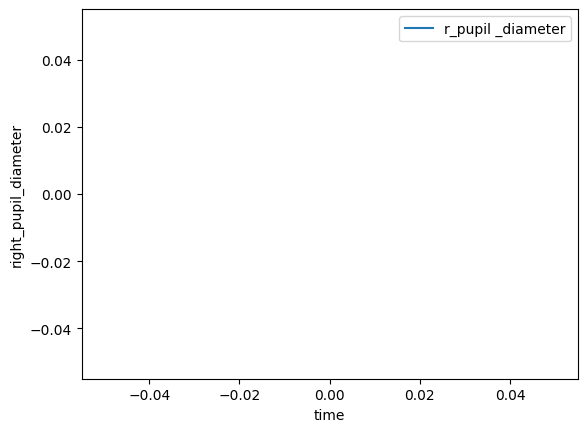

In [8]:
sns.lineplot(data=et_df, x='time', y='right_pupil_diameter', label='r_pupil _diameter')

# Physio

In [7]:
PS = data[streams_collected.index('OpenSignals')]
# Get the column names
column_labels = [PS['info']['desc'][0]['channels'][0]['channel'][i]['label'][0] for i in range(len(PS['info']['desc'][0]['channels'][0]['channel']))]
ps_df = pd.DataFrame(data=PS['time_series'], columns=column_labels)
ps_df['lsl_time_stamp'] = PS['time_stamps']
ps_df['time'] = (PS['time_stamps'] - PS['time_stamps'][0])/1000

In [8]:
ps_exp = get_event_data('Experiment', ps_df, stim_df=stim_df)
start = ps_exp['lsl_time_stamp'].values[0]
stop = ps_exp['lsl_time_stamp'].values[-1]
phys_dur = stop - start
phys_dur

np.float64(1775.8445838444168)

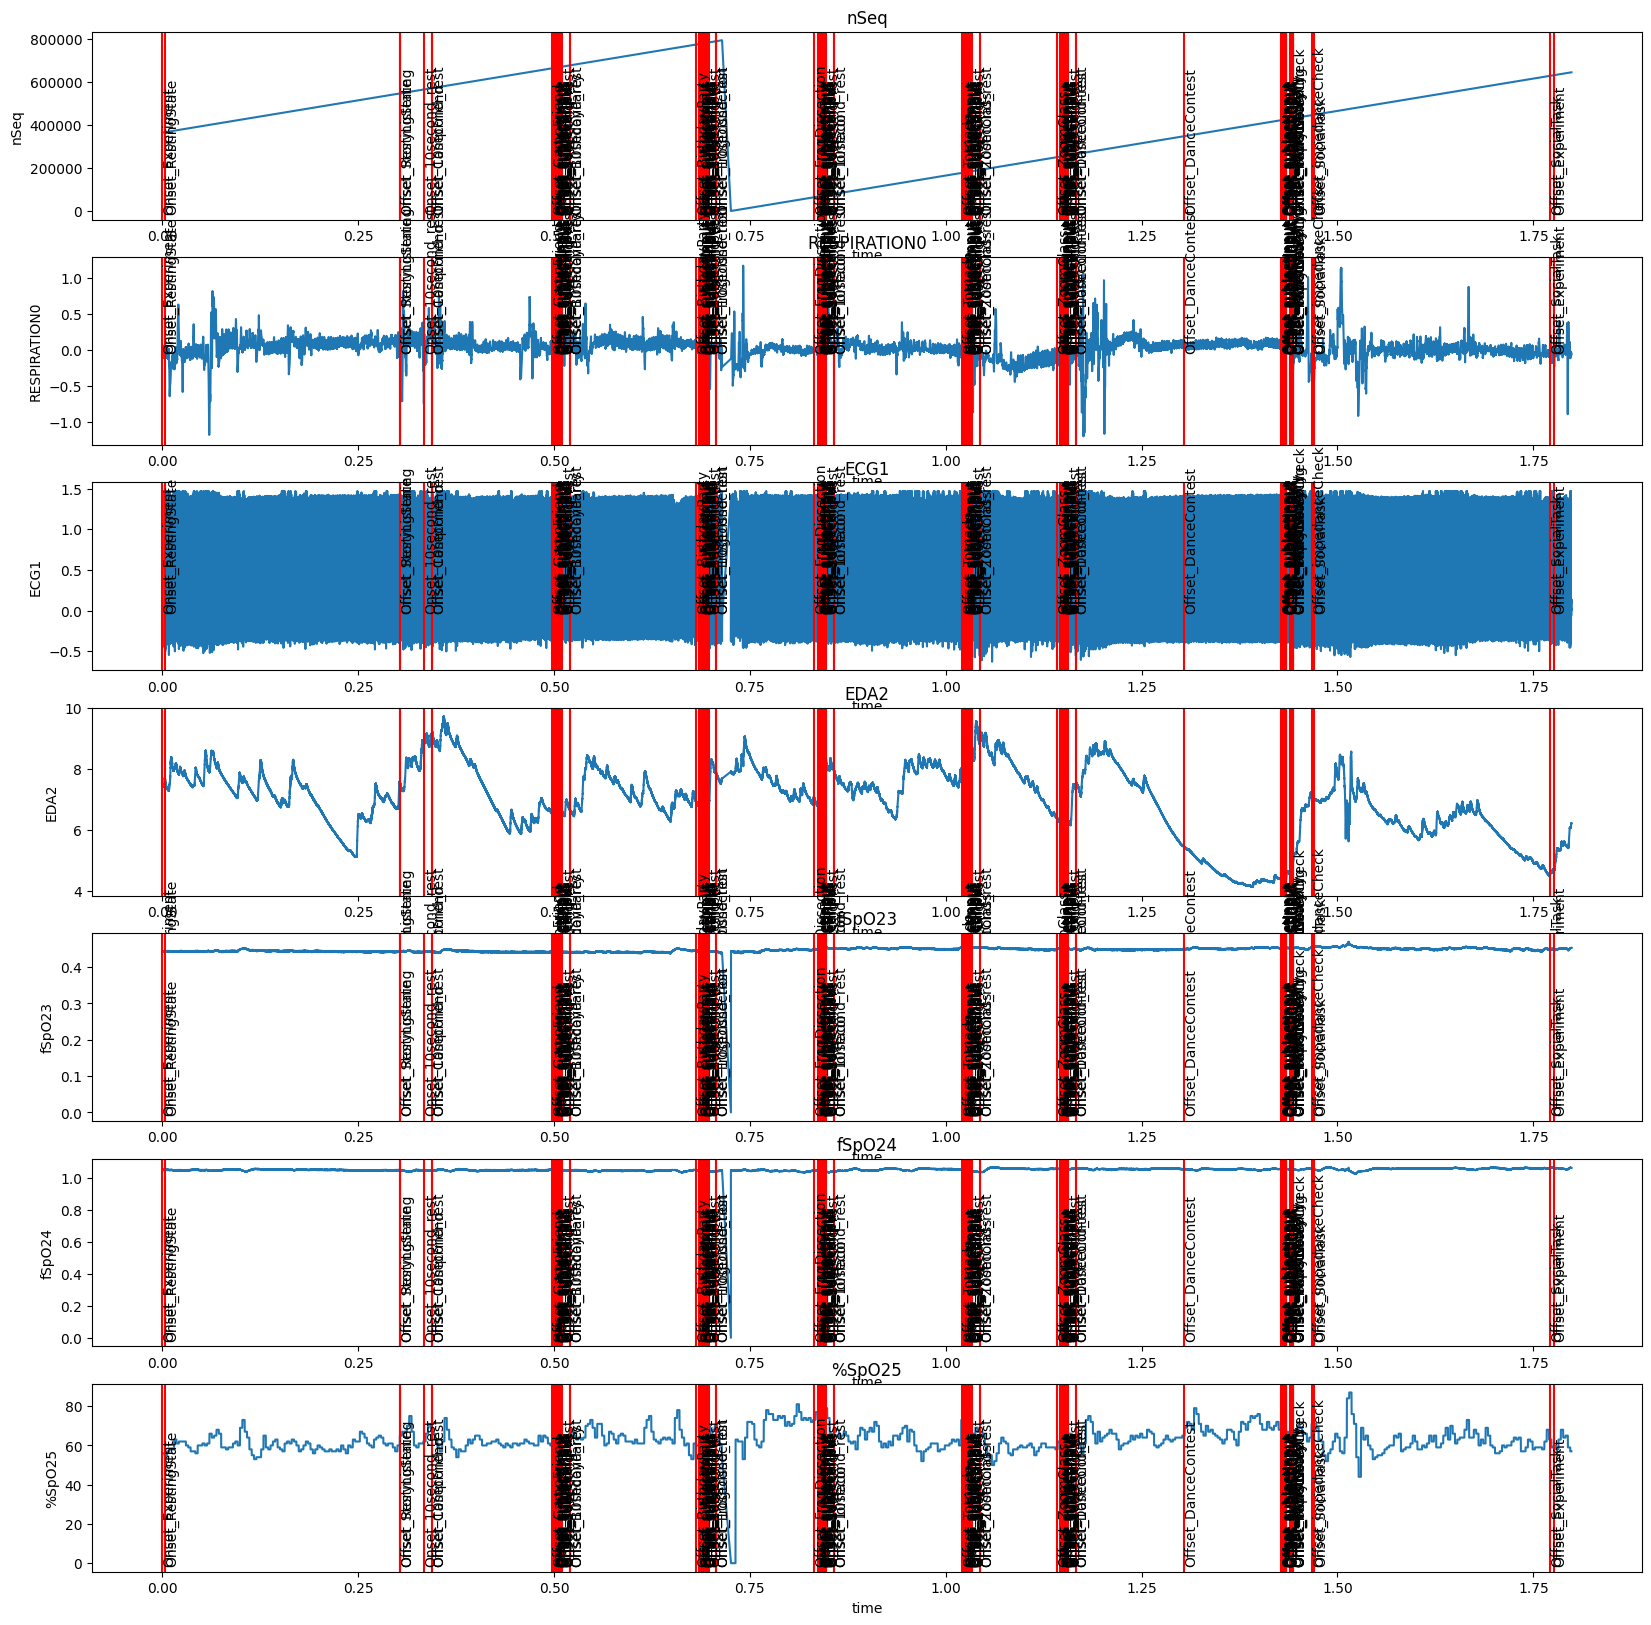

In [9]:
    
'''
# Plot every column in one plot
'''
# confirm all events are in the stim_df
evs = stim_df.loc[stim_df.event != 'psychopy_time_stamp']

f, ax = plt.subplots(figsize=(20,20), nrows=len(column_labels), ncols=1)

# Make this one figure with subplots
for i, col in enumerate(column_labels):
    
    #plt.plot(ps_df.loc[(ps_df['time'] > 1000) & (ps_df['time'] < 1015), col])
    #plt.subplot(ps_df['time'], ps_df[col], ax= ax[i])
    sns.lineplot(data=ps_df, x='time', y=col, ax=ax[i])
    # Place and Vline at every event in evs with onset and offset
    for event in evs.iterrows():
        # If the word Onset or Offset is in the event, plot a vertical line at the time of the event

        if "Onset" in event[1]['event'] or "Offset" in event[1]['event']:
            ax[i].axvline(event[1]['time'], color='r')
            ax[i].text(event[1]['time'], 0, event[1]['event'], rotation=90)
        
    ax[i].set_title(col)
    #plt.show()

In [ ]:
physio_resting_state = get_event_data('RestingState', ps_df)
fig, ax = plt.subplots(figsize=(20,20), nrows=len(column_labels), ncols=1)

# Make this one figure with subplots
#for i, col in enumerate(['RESPIRATION0', 'fSpO21', 'fSpO22', '%SpO23']):
for i, col in enumerate(column_labels):
    

    #plt.plot(ps_df.loc[(ps_df['time'] > 1000) & (ps_df['time'] < 1015), col])
    #plt.subplot(ps_df['time'], ps_df[col], ax= ax[i])
    sns.lineplot(data=physio_resting_state[:5000], x='time', y=col, ax=ax[i])

# Linking Microphone Data to Video Data

In [10]:
mic_data = data[streams_collected.index('Microphone')]
mic_df = pd.DataFrame(mic_data['time_series'], columns=['int_array'])
mic_df['bytestring'] = mic_df['int_array'].apply(lambda x: np.array(x).tobytes())
#mic_df['time'] = (mic_data['time_stamps'] - mic_data['time_stamps'][0])/441000

mic_df['lsl_time_stamp'] = mic_data['time_stamps']
mic_df['time_delta'] = mic_df['lsl_time_stamp'].diff()

mic_df.head()

,int_array,bytestring,lsl_time_stamp,time_delta
0,12,b'\x0c\x00\x00\x00\x00\x00\x00\x00',916554.445797,NaN
1,13,b'\r\x00\x00\x00\x00\x00\x00\x00',916554.445819,0.000023
2,11,b'\x0b\x00\x00\x00\x00\x00\x00\x00',916554.445842,0.000023
3,12,b'\x0c\x00\x00\x00\x00\x00\x00\x00',916554.445865,0.000023
4,15,b'\x0f\x00\x00\x00\x00\x00\x00\x00',916554.445887,0.000023


In [13]:
start = mic_df['lsl_time_stamp'].values[0]
stop = mic_df['lsl_time_stamp'].values[-1]
print (stop - start)

1460.6834189073415


In [11]:
precision = 1e-8
fs = 44100
sum(abs(mic_df.time_delta - 1/fs) < precision) == len(mic_df) - 1


True

## checking duration of mic data

In [12]:
mic_story = get_event_data('StoryListening', mic_df, stim_df=stim_df)
start = mic_story['lsl_time_stamp'].values[0]
stop = mic_story['lsl_time_stamp'].values[-1]
mic_story_dur = stop - start
print(mic_story_dur)

story_start = stim_df.loc[stim_df.event == 'Onset_StoryListening', 'lsl_time_stamp'].values[0]
story_end = stim_df.loc[stim_df.event == 'Offset_StoryListening', 'lsl_time_stamp'].values[0]
story_dur = story_end - story_start
story_dur

1119.7918730190722


np.float64(1139.6484733419493)

In [13]:
sns.lineplot(y='time_delta', x = 'time', data=mic_df)

ValueError: Could not interpret value `time` for `x`. An entry with this name does not appear in `data`.

In [24]:
#conversation_onset_stim = stim_df.loc[stim_df.event == 'Onset_SocialTask', 'time'].values[0]
#conversation_offset_stim = stim_df.loc[stim_df.event == 'Offset_SocialTask', 'time'].values[0]
#
# convo = mic_df.loc[(mic_df['time'] > conversation_onset_stim ) & (mic_df['time'] < conversation_offset_stim), 'int_array'].values
convo = get_event_data('Tornado', mic_df, stim_df=stim_df)
convo


,int_array,bytestring,lsl_time_stamp,time_delta
23529260,22,b'\x16\x00\x00\x00\x00\x00\x00\x00',917088.092660,0.000023
23529261,22,b'\x16\x00\x00\x00\x00\x00\x00\x00',917088.092683,0.000023
23529262,22,b'\x16\x00\x00\x00\x00\x00\x00\x00',917088.092705,0.000023
23529263,26,b'\x1a\x00\x00\x00\x00\x00\x00\x00',917088.092728,0.000023
23529264,24,b'\x18\x00\x00\x00\x00\x00\x00\x00',917088.092751,0.000023
...,...,...,...,...
30726959,-11,b'\xf5\xff\xff\xff\xff\xff\xff\xff',917251.337466,0.000023
30726960,-10,b'\xf6\xff\xff\xff\xff\xff\xff\xff',917251.337489,0.000023
30726961,-7,b'\xf9\xff\xff\xff\xff\xff\xff\xff',917251.337512,0.000023
30726962,-9,b'\xf7\xff\xff\xff\xff\xff\xff\xff',917251.337534,0.000023


In [ ]:
f, ax = plt.subplots(figsize=(15, 5))
plt.plot(mic_df.lsl_time_stamp, mic_df.int_array)
for event in evs.loc[evs.event.str.contains('Tornado')].iterrows():
    ax.axvline(event[1]['lsl_time_stamp'], color='r')
    ax.text(event[1]['lsl_time_stamp'], 0, event[1]['event'], rotation=90)
        

In [25]:
sd.play(convo.int_array.values)

# Video Data
Now lets open the video frames

In [14]:
# Identify the frames we're interested in
cam_data = data[streams_collected.index('WebcamStream')]

#cam_df = pd.DataFrame(cam['time_series'], columns=['frame'])
#cam_df['lsl_timestamps'] = cam['time_stamps']
#cam_df['time'] = cam_df['lsl_timestamps'] - cam_df['lsl_timestamps'][0]
cam_data['time_series'][0]
frame_nums = [int(i[0]) for i in cam_data['time_series']]
time_pre = [float(i[1]) for i in cam_data['time_series']]
time_evnt_ms = [float(i[2]) for i in cam_data['time_series']]
time_post = [float(i[3]) for i in cam_data['time_series']]


cam_df = pd.DataFrame({'frame_num': frame_nums, 
                    'time_pre': time_pre, 
                    'cap_time_ms': time_evnt_ms,
                    'time_post': time_post,
                    'lsl_time_stamp': cam_data['time_stamps']})



cam_df['frame_time_sec'] = (cam_df.cap_time_ms - cam_df.cap_time_ms[0])/1000
cam_df['lsl_time_sec'] = cam_df.lsl_time_stamp #- cam_df.lsl_time_stamp[0]
cam_df['time'] = (cam_df.lsl_time_stamp - cam_df.lsl_time_stamp[0])/1000

## checking duration of cam data

In [15]:
exp_start = stim_df.loc[stim_df.event == 'Onset_Experiment', 'lsl_time_stamp'].values[0]
exp_end = stim_df.loc[stim_df.event == 'Offset_Experiment', 'lsl_time_stamp'].values[0]
experiment_dur = exp_end - exp_start
print(experiment_dur)

cam_exp = get_event_data('Experiment', cam_df, stim_df=stim_df)
start = cam_exp['lsl_time_stamp'].values[0]
stop = cam_exp['lsl_time_stamp'].values[-1]
cam_dur = stop - start
print(cam_dur)


1775.8462822888978
1775.4980127461022


In [ ]:
#vid_convo = cam_df.loc[(cam_df['lsl_time_sec'] > conversation_onset_stim ) & (cam_df['lsl_time_sec'] < conversation_offset_stim)]
vid_convo = get_event_data('SocialTask', cam_df)
vid_convo_frames = vid_convo['frame_num'].values

A goal here is to identify timestamps in the microphone data and their corresponding frames in the video data

In [ ]:
sd.play(convo.int_array.values, 44100)


In [ ]:
# Use cv2 to read the video file and play the frames
cap = cv2.VideoCapture('C:/Users/Admin/Documents/code/MOBI2024/CUNY_FACIAL/video_files/2222_CUNY_Face_Full_Protocol.avi')
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# play the video
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        if cap.get(1) in vid_convo_frames:
            cv2.imshow('Frame', frame)
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        
        cv2.imshow('Frame', frame)
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
        else:
            continue
    else:
        break


In [ ]:
# Use cv2 to read the video file and play the frames
cap = cv2.VideoCapture('C:/Users/Admin/Documents/code/MOBI2024/CUNY_FACIAL/video_files/2222_CUNY_Face_Full_Protocol.avi')
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# play the video
while(cap.isOpened()):
    sd.play(convo.int_array.values, 44100)
    ret, frame = cap.read()
    if ret == True:
        if cap.get(1) in vid_convo_frames:
            cv2.imshow('Frame', frame)
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        else:
            continue
    else:
        break


# Eye Tracking

In [ ]:
ET = data[streams_collected.index('Tobii')]
et_dat = ET['time_series']
# Get the column names
column_labels = [ET['info']['desc'][0]['channels'][0]['channel'][i]['label'][0] for i in range(len(ET['info']['desc'][0]['channels'][0]['channel']))]

et_df = pd.DataFrame(data=et_dat, columns=column_labels)
et_df['time'] = (ET['time_stamps'] - ET['time_stamps'][0])/1000
et_df.head()

In [25]:
ET

{'info': defaultdict(list,
             {'name': ['Tobii'],
              'type': ['ET'],
              'channel_count': ['31'],
              'channel_format': ['float32'],
              'source_id': ['tobii-prp://TPFC2-010201444964'],
              'nominal_srate': ['120.0000000000000'],
              'version': ['1.100000000000000'],
              'created_at': ['3312096.975980700'],
              'uid': ['307c7266-74bd-4a08-b2cd-8651c5e8f52b'],
              'session_id': ['default'],
              'hostname': ['C3-EYE-TRACKING'],
              'v4address': [None],
              'v4data_port': ['16572'],
              'v4service_port': ['16572'],
              'v6address': [None],
              'v6data_port': ['16572'],
              'v6service_port': ['16572'],
              'desc': [defaultdict(list,
                           {'manufacturer': ['Tobii'],
                            'channels': [defaultdict(list,
                                         {'channel': [defaultdict(li

In [ ]:
ps_df.time.describe()

In [ ]:
# Plot left_pupil_diameter and right_pupil_diameter
plt.figure(figsize=(20, 4))
plt.plot(et_df['left_pupil_diameter'][:1300000], label='left_pupil_diameter');
plt.plot(et_df['right_pupil_diameter'][:1300000], label='right_pupil_diameter');
plt.title('Pupil diameter data');

In [ ]:

evnt_of_interest = 'CampFriend'
onset = stim_df.loc[stim_df.event == 'Onset_'+ evnt_of_interest, 'time'].values[0]
offset = stim_df.loc[stim_df.event == 'Offset_'+ evnt_of_interest, 'time'].values[0]
left_x = et_df.loc[(et_df.time > onset) & (et_df.time < offset), 'left_gaze_point_on_display_area_0']
left_y = et_df.loc[(et_df.time > onset) & (et_df.time < offset), 'left_gaze_point_on_display_area_1']
left = pd.DataFrame({'x': left_x, 'y': left_y})
# Right
right_x = et_df.loc[(et_df.time > onset) & (et_df.time < offset), 'right_gaze_point_on_display_area_0']
right_y = et_df.loc[(et_df.time > onset) & (et_df.time < offset), 'right_gaze_point_on_display_area_1']
right = pd.DataFrame({'x': right_x, 'y': right_y})
fig, ax = plt.subplots( figsize=(20, 10))
sns.scatterplot(data=right, x='x', y='y', color='r')
#ax[0].set_title('Right eye')
sns.scatterplot(data=left, x='x', y='y', color='b')
#ax[1].set_title('Left eye')

In [ ]:
ET = data[streams_collected.index('Tobii')]
et_dat = ET['time_series']

In [ ]:
# Get the units associated with each eyetracking variable
ET['info']['desc'][0]#['channels'][0]['channel'][0]['unit'][0]

# EEG

In [ ]:
EEG = data[streams_collected.index('EGI NetAmp 0')]
eeg_dat = pd.DataFrame(EEG['time_series'])
#eeg_dat['lsl_time_stamp'] = EEG['time_stamps']

Apply Notch Filter?

In [ ]:
def apply_notch_filter(data, fs, f0, Q):
    nyquist = 0.5 * fs
    w0 = f0 / nyquist
    b, a = iirnotch(w0, Q)
    return filtfilt(b, a, data)

filtered_eeg = eeg_dat.apply(lambda x: apply_notch_filter(x, 1000, 60, 30))

In [ ]:
# plot the EEG data
plt.figure(figsize=(20, 10))
plt.plot(filtered_eeg[:10000]);


In [ ]:
rest_eeg = filtered_eeg #eeg_dat[:-1] #get_event_data('RestingState', eeg_dat)
from scipy.signal import spectrogram

plt.figure(figsize=(10, 4))

for column in rest_eeg.columns:
    f, t, Sxx = spectrogram(rest_eeg[column], fs=1000)

    plt.pcolormesh(t, f, 10 *np.log10(Sxx), shading='nearest')

plt.colorbar(label='Power/Frequency [Hz]')
plt.ylabel('Freq')
plt.xlabel('time')
plt.tight_layout()
plt.show()

In [ ]:
from scipy.signal import spectrogram

plt.figure(figsize=(10, 4))

for column in eeg_dat.columns:
    f, t, Sxx = spectrogram(eeg_dat[column], fs=250)

    plt.pcolormesh(t, f, 10 *np.log10(Sxx), shading='nearest')

plt.colorbar(label='Power/Frequency [Hz]')
plt.ylabel('Freq')
plt.xlabel('time')
plt.tight_layout()
plt.show()

In [24]:
eeg_dat = data[streams_collected.index('EGI NetAmp 0')]
eeg_df = pd.DataFrame(eeg_dat['time_series'])
eeg_df['lsl_time_stamp'] = eeg_dat['time_stamps']

eeg_exp = get_event_data('Experiment', eeg_df, stim_df=stim_df)
start = eeg_exp['lsl_time_stamp'].values[0]
stop = eeg_exp['lsl_time_stamp'].values[-1]
eeg_dur = stop - start

# List of variables to include in the DataFrame
dur_variables = ['experiment_dur', 'eyetracking_dur', 'phys_dur', 'cam_dur', 'mic_story_dur', 'story_dur', 'eeg_dur']
variables = {name: globals()[name] for name in dur_variables}

# Convert the dictionary to a pandas DataFrame
durations_df = pd.DataFrame(list(variables.items()), columns=['Variable Name', 'Variable Value'])
durations_df

,Variable Name,Variable Value
0,experiment_dur,1775.846282
1,eyetracking_dur,1775.466180
2,phys_dur,1775.844584
3,cam_dur,1775.498013
4,mic_story_dur,1119.791873
5,story_dur,1139.648473
6,eeg_dur,1775.845401
